In [1]:
from google.colab import files
import pandas as pd
import matplotlib.pyplot as plt
from imblearn.over_sampling import SMOTE
from imblearn.under_sampling import RandomUnderSampler
from imblearn.combine import SMOTEENN
from imblearn.pipeline import Pipeline
import torch
import numpy as np

In [2]:
# importamos los 3 documentos
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
# Cargar ambos archivos
import pandas as pd

# Cargar datos
features = pd.read_parquet("/content/drive/MyDrive/Archivos_ALeRCE/features_cleaned.parquet", engine="pyarrow")
cross = pd.read_csv("/content/drive/MyDrive/Archivos_ALeRCE/dfcrossmatches_prioritized_v7.0.1.csv")
detecciones = pd.read_csv("/content/drive/MyDrive/Archivos_ALeRCE/detections_SNe_v7.0.1.csv")

# Unir por 'oid' y quedarnos con la clase
df_merged = features.merge(
    cross[['oid', 'classALeRCE']],
    on='oid', how='left'
)

# Filtrar sólo supernovas (SN*) y SLSN
df_sn = df_merged[
    (df_merged['classALeRCE'].str.startswith('SN', na=False)) |
    (df_merged['classALeRCE'] == 'SLSN')
].copy()

# Normalizar subclases: SNIIb, SNIIn, y otros SNII* → SNII
def map_sn(cls):
    if pd.isna(cls):
        return cls
    if cls == 'SLSN':
        return 'SLSN'
    if cls.startswith('SNIa'):
        return 'SNIa'
    if cls.startswith('SNIbc'):
        return 'SNIbc'
    if cls.startswith('SNII'):  # capta SNII, SNIIb, SNIIn, etc.
        return 'SNII'
    return cls

df_sn['classALeRCE_four'] = df_sn['classALeRCE'].apply(map_sn)

# Quitar filas fuera de las 4 clases
df_sn = df_sn[df_sn['classALeRCE_four'].isin(['SNIa','SNIbc','SNII','SLSN'])].copy()

print(df_sn.shape)
print(df_sn['classALeRCE_four'].value_counts())


(1823, 181)
classALeRCE_four
SNIa     1364
SNII      339
SNIbc      96
SLSN       24
Name: count, dtype: int64


In [4]:
import pandas as pd

features = pd.read_parquet("/content/drive/MyDrive/Archivos_ALeRCE/features_cleaned.parquet", engine="pyarrow")
cross = pd.read_csv("/content/drive/MyDrive/Archivos_ALeRCE/dfcrossmatches_prioritized_v7.0.1.csv")

df = features.merge(cross[['oid','classALeRCE']], on='oid', how='left')

mask_sn = df['classALeRCE'].str.startswith('SN', na=False) | (df['classALeRCE']=='SLSN')
df_sn = df[mask_sn].copy()

# Mapear a 4 clases (SNIa, SNIbc, SNII, SLSN)
def map_sn(cls):
    if pd.isna(cls): return np.nan
    if cls == 'SLSN': return 'SLSN'
    if cls.startswith('SNIa'): return 'SNIa'
    if cls.startswith('SNIbc'): return 'SNIbc'
    if cls.startswith('SNII'): return 'SNII'  # SNII, SNIIb, SNIIn → SNII Esta es la indexación de las clases en las del tipo SNII!!!
    return np.nan

df_sn['class4'] = df_sn['classALeRCE'].apply(map_sn)
df_sn = df_sn[df_sn['class4'].isin(['SNIa','SNIbc','SNII','SLSN'])].copy()

# Separar X, y
feature_cols = [c for c in df_sn.columns if c not in ['oid','classALeRCE','class4']]
X = df_sn[feature_cols].values.astype('float32')
y = df_sn['class4'].values

# Codificación de etiquetas
from sklearn.preprocessing import LabelEncoder
le = LabelEncoder()
y_int = le.fit_transform(y)  # 0..3
num_classes = len(le.classes_)
print('Clases:', list(le.classes_))


Clases: ['SLSN', 'SNII', 'SNIa', 'SNIbc']


In [5]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train_int, y_test_int = train_test_split(
    X, y_int, test_size=0.20, random_state=42, stratify=y_int)


In [6]:
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline

prep = Pipeline([
    ('imp', SimpleImputer(strategy='constant', fill_value=0.0)), #Aquí el modelo presentó un mejor desempeño con 0 que con -999
    ('sc', StandardScaler())   #Preprocesamiento de ADAM!!!
])

X_train_p = prep.fit_transform(X_train)
X_test_p  = prep.transform(X_test)


In [7]:
import numpy as np
import tensorflow as tf
from tensorflow import keras

def get_latent_features_keras(model, X_data):
    # Usamos model.layers[3].output para obtener la salida de la capa Dense de 128.
    feature_extractor = keras.Model(
        inputs=model.input,
        outputs=model.layers[3].output # Capa Dense (128)
    )

    # 3. Predecir (Extraer) las características latentes
    latent_features = feature_extractor.predict(X_data, verbose=0)

    return latent_features

In [8]:
#Se define la mlp.

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers

tf.random.set_seed(42)

def build_mlp(input_dim, num_classes, dropout=0.5):
    inp = keras.Input(shape=(input_dim,))
    x = layers.Dense(256, activation='relu')(inp)
    x = layers.Dropout(dropout)(x)
    x = layers.Dense(128, activation='relu')(x)
    x = layers.Dropout(dropout)(x)
    out = layers.Dense(num_classes, activation='softmax')(x)
    model = keras.Model(inp, out)
    model.compile(
        optimizer=keras.optimizers.Adam(learning_rate=1e-3),
        loss='sparse_categorical_crossentropy',
        metrics=['accuracy']
    )
    return model

model = build_mlp(X_train_p.shape[1], num_classes)

# Pesos de clase
from sklearn.utils.class_weight import compute_class_weight
import numpy as np
class_weights = compute_class_weight(
    class_weight='balanced',
    classes=np.unique(y_train_int),
    y=y_train_int
)
class_weights = {i:w for i,w in enumerate(class_weights)}
class_weights


{0: np.float64(19.18421052631579),
 1: np.float64(1.345018450184502),
 2: np.float64(0.3340971585701192),
 3: np.float64(4.733766233766234)}

In [9]:
# Callbacks: early stopping y mejor modelo
cb = [
    keras.callbacks.EarlyStopping(monitor='val_loss', patience=15, restore_best_weights=True),
    keras.callbacks.ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=5, min_lr=1e-5)
]

history = model.fit(
    X_train_p, y_train_int,
    epochs=200,
    batch_size=256,
    validation_split=0.2,
    callbacks=cb,
    class_weight=class_weights,
    verbose=2
)


Epoch 1/200
5/5 - 1s - 255ms/step - accuracy: 0.1775 - loss: 2.0230 - val_accuracy: 0.3459 - val_loss: 1.3112 - learning_rate: 1.0000e-03
Epoch 2/200
5/5 - 0s - 21ms/step - accuracy: 0.3053 - loss: 1.8114 - val_accuracy: 0.3836 - val_loss: 1.2030 - learning_rate: 1.0000e-03
Epoch 3/200
5/5 - 0s - 20ms/step - accuracy: 0.3791 - loss: 1.5689 - val_accuracy: 0.4966 - val_loss: 1.1402 - learning_rate: 1.0000e-03
Epoch 4/200
5/5 - 0s - 19ms/step - accuracy: 0.4185 - loss: 1.3221 - val_accuracy: 0.5753 - val_loss: 1.0983 - learning_rate: 1.0000e-03
Epoch 5/200
5/5 - 0s - 20ms/step - accuracy: 0.4280 - loss: 1.1272 - val_accuracy: 0.6267 - val_loss: 1.0767 - learning_rate: 1.0000e-03
Epoch 6/200
5/5 - 0s - 20ms/step - accuracy: 0.4417 - loss: 1.1100 - val_accuracy: 0.6438 - val_loss: 1.0558 - learning_rate: 1.0000e-03
Epoch 7/200
5/5 - 0s - 23ms/step - accuracy: 0.5069 - loss: 0.9910 - val_accuracy: 0.6541 - val_loss: 1.0204 - learning_rate: 1.0000e-03
Epoch 8/200
5/5 - 0s - 28ms/step - accur

In [10]:
from sklearn.metrics import classification_report, confusion_matrix
import numpy as np

y_proba = model.predict(X_test_p)
y_pred = np.argmax(y_proba, axis=1)

print(classification_report(y_test_int, y_pred, target_names=le.classes_))
print(confusion_matrix(y_test_int, y_pred))


12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step 
              precision    recall  f1-score   support

        SLSN       1.00      0.20      0.33         5
        SNII       0.63      0.76      0.69        68
        SNIa       0.91      0.85      0.88       273
       SNIbc       0.20      0.26      0.23        19

    accuracy                           0.79       365
   macro avg       0.68      0.52      0.53       365
weighted avg       0.82      0.79      0.80       365

[[  1   3   1   0]
 [  0  52  14   2]
 [  0  23 232  18]
 [  0   5   9   5]]


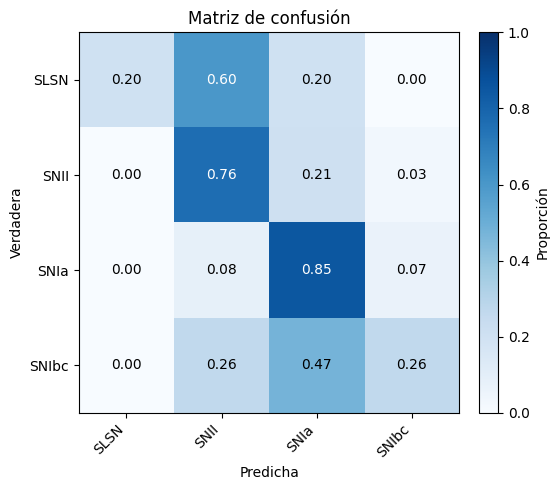

In [11]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix

# y_test_int: enteros 0..3; y_pred: predicciones 0..3; le.classes_: ['SLSN','SNIa','SNIbc','SNII'] según el encoder
cm = confusion_matrix(y_test_int, y_pred, labels=np.arange(len(le.classes_)))
cm_pct = cm.astype(float) / cm.sum(axis=1, keepdims=True)
cm_pct = np.nan_to_num(cm_pct)  # por si alguna fila queda vacía

fig, ax = plt.subplots(figsize=(6,5))
im = ax.imshow(cm_pct, cmap='Blues', vmin=0, vmax=1)

# ticks y etiquetas
ax.set_xticks(np.arange(len(le.classes_)))
ax.set_yticks(np.arange(len(le.classes_)))
ax.set_xticklabels(le.classes_, rotation=45, ha='right')
ax.set_yticklabels(le.classes_)
ax.set_xlabel('Predicha')
ax.set_ylabel('Verdadera')
ax.set_title('Matriz de confusión')

# anotar porcentajes
for i in range(cm_pct.shape[0]):
    for j in range(cm_pct.shape[1]):
        ax.text(j, i, f'{cm_pct[i, j]:.2f}', ha='center', va='center',
                color='black' if cm_pct[i, j] < 0.5 else 'white')

fig.colorbar(im, ax=ax, fraction=0.046, pad=0.04, label='Proporción')
plt.tight_layout()
plt.show()


In [90]:
# Ejecutar la función para extraer las características
X_latent = get_latent_features_keras(model, X_test_p)
y_latent = y_test_int # Las etiquetas verdaderas asociadas

print(f"Forma de las características latentes: {X_latent.shape}")
print(f"Forma de las etiquetas asociadas: {y_latent.shape}")

Forma de las características latentes: (365, 128)
Forma de las etiquetas asociadas: (365,)


In [91]:
import time
import numpy as np
import umap
from sklearn.manifold import TSNE

# Nombres de las 4 clases de supernovas (obtenidas del LabelEncoder 'le')
class_names_sn = list(le.classes_)

print("\n--- Reducción de Dimensionalidad ---")


import time
import umap

print("\n--- UMAP Antes de MLP ---")
time_start = time.time()


reducer_umap_before = umap.UMAP(n_components=2, random_state=42)
Z_2D_umap_before = reducer_umap_before.fit_transform(X_test_p)
print(f"UMAP (Antes de MLP) completado en: {time.time() - time_start:.2f} segundos. Forma: {Z_2D_umap_before.shape}")


time_start = time.time()
reducer_umap = umap.UMAP(n_components=2, random_state=42)
Z_2D_umap = reducer_umap.fit_transform(X_latent)
print(f"UMAP completado en: {time.time() - time_start:.2f} segundos. Forma: {Z_2D_umap.shape}")

time_start = time.time()
reducer_tsne = TSNE(n_components=2, verbose=1, random_state=42, n_jobs=-1)
Z_2D_tsne = reducer_tsne.fit_transform(X_latent)
print(f"t-SNE completado en: {time.time() - time_start:.2f} segundos. Forma: {Z_2D_tsne.shape}")



--- Reducción de Dimensionalidad ---

--- UMAP Antes de MLP ---


/usr/local/lib/python3.12/dist-packages/umap/umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(


UMAP (Antes de MLP) completado en: 0.72 segundos. Forma: (365, 2)


/usr/local/lib/python3.12/dist-packages/umap/umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(


UMAP completado en: 0.67 segundos. Forma: (365, 2)
[t-SNE] Computing 91 nearest neighbors...
[t-SNE] Indexed 365 samples in 0.001s...
[t-SNE] Computed neighbors for 365 samples in 0.016s...
[t-SNE] Computed conditional probabilities for sample 365 / 365
[t-SNE] Mean sigma: 1.620249
[t-SNE] KL divergence after 250 iterations with early exaggeration: 56.521465
[t-SNE] KL divergence after 1000 iterations: 0.804365
t-SNE completado en: 2.86 segundos. Forma: (365, 2)


In [92]:
from sklearn.svm import OneClassSVM
import numpy as np

# Almacena los modelos OCSVM entrenados
ocsvm_models = {}
NU_PARAM = 0.1

print("\n--- Entrenamiento de 4 Modelos One-Class SVM (K-SVDD) ---")

# Iteramos sobre las 4 clases de Supernovas (0 a 3)
for class_id in range(num_classes):
    # 1. Aislar las muestras de la clase actual
    X_class_train = X_latent[y_latent == class_id]

    if len(X_class_train) == 0:
        print(f"Advertencia: No hay muestras para la clase {class_id}. Omitiendo.")
        continue

    # 2. Inicializar y entrenar el OCSVM
    ocsvm = OneClassSVM(
        kernel='rbf',
        nu=NU_PARAM,
        gamma='auto'
    )

    ocsvm.fit(X_class_train)

    ocsvm_models[class_id] = ocsvm
    # Recuperamos el nombre de la clase para una mejor visualización (si 'le' está disponible)
    try:
        class_name = le.classes_[class_id]
    except NameError:
        class_name = f"Clase {class_id}"

    print(f"OCSVM entrenado para {class_name} (N={len(X_class_train)})")


--- Entrenamiento de 4 Modelos One-Class SVM (K-SVDD) ---
OCSVM entrenado para SLSN (N=5)
OCSVM entrenado para SNII (N=68)
OCSVM entrenado para SNIa (N=273)
OCSVM entrenado para SNIbc (N=19)


In [93]:
import matplotlib.pyplot as plt

def plot_latent_space(Z_2D, y_labels_int, title, class_names, custom_colors=None):
    """Grafica el espacio latente 2D coloreado por clases."""
    fig, ax = plt.subplots(figsize=(8, 8))

    # Grafica cada clase por separado para generar la leyenda
    for i, class_name in enumerate(class_names):
        mask = (y_labels_int == i)

        # Usa color personalizado si está disponible, sino usa colormap
        if custom_colors and class_name in custom_colors:
            color = custom_colors[class_name]
        else:
            cmap = plt.cm.get_cmap('Spectral', len(class_names))
            color = cmap(i)

        ax.scatter(
            Z_2D[mask, 0],
            Z_2D[mask, 1],
            label=class_name,
            color=color,
            alpha=0.7,
            s=15
        )

    ax.set_title(title)
    ax.legend(title='Clases', bbox_to_anchor=(1.05, 1), loc='upper left')
    ax.set_xlabel('Componente 1')
    ax.set_ylabel('Componente 2')
    plt.tight_layout()
    plt.show()


def plot_umap_by_pred(Z, y_pred, class_names, custom_colors=None):
    """Grafica UMAP coloreado por predicción MSVDD."""
    plt.figure(figsize=(8, 7))

    for i, name in enumerate(class_names):
        mask = (y_pred == i)

        # Usa color personalizado si está disponible, sino usa colormap
        if custom_colors and name in custom_colors:
            color = custom_colors[name]
        else:
            cmap = plt.cm.get_cmap("Spectral", len(class_names))
            color = cmap(i)

        plt.scatter(
            Z[mask, 0], Z[mask, 1],
            s=20, alpha=0.8,
            color=color,
            label=f"{name}"
        )

    plt.title("UMAP – Clusters DESPUÉS del Multiclass (Predicción MSVDD)")
    plt.xlabel("UMAP-1")
    plt.ylabel("UMAP-2")
    plt.legend(title="Predicción MSVDD", bbox_to_anchor=(1.05, 1), loc="upper left")
    plt.tight_layout()
    plt.show()


def plot_umap_anomalies(Z, anomaly_score, color_normal='#95a5a6', color_anomaly='#e74c3c'):
    """Grafica UMAP con anomalías destacadas."""
    plt.figure(figsize=(8, 7))

    normal = anomaly_score >= 0
    anomalous = anomaly_score < 0

    plt.scatter(
        Z[normal, 0], Z[normal, 1],
        s=20, alpha=0.5, color=color_normal,
        label="Normales"
    )
    plt.scatter(
        Z[anomalous, 0], Z[anomalous, 1],
        s=80, alpha=1.0, color=color_anomaly, marker="X",
        label="Anomalías MSVDD"
    )

    plt.title("UMAP – Anomalías detectadas por Multiclass SVDD")
    plt.xlabel("UMAP-1")
    plt.ylabel("UMAP-2")
    plt.legend()
    plt.tight_layout()
    plt.show()

In [94]:
# Definición de colores personalizados para las 4 clases de SN
custom_colors = {
    'SLSN': 'red',
    'SNIa': 'lightskyblue',
    'SNIbc': 'mediumvioletred',
    'SNII': 'navy'
}

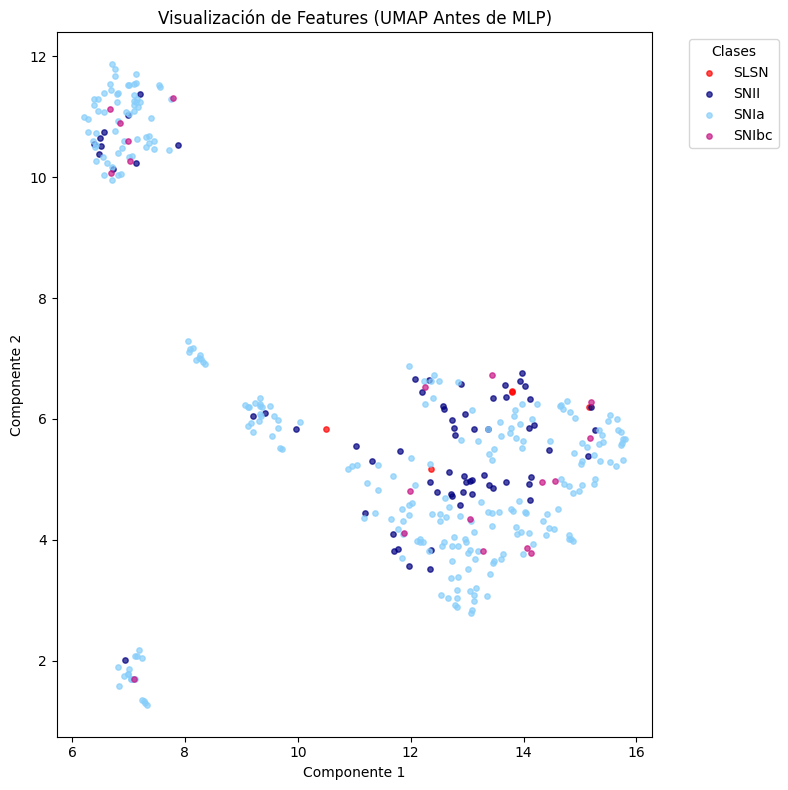

In [95]:
# 1. ANTES DE LA MLP
plot_latent_space(
    Z_2D_umap_before,
    y_latent,
    'Visualización de Features (UMAP Antes de MLP)',
    class_names_sn,
    custom_colors=custom_colors  # Agrega este parámetro
)

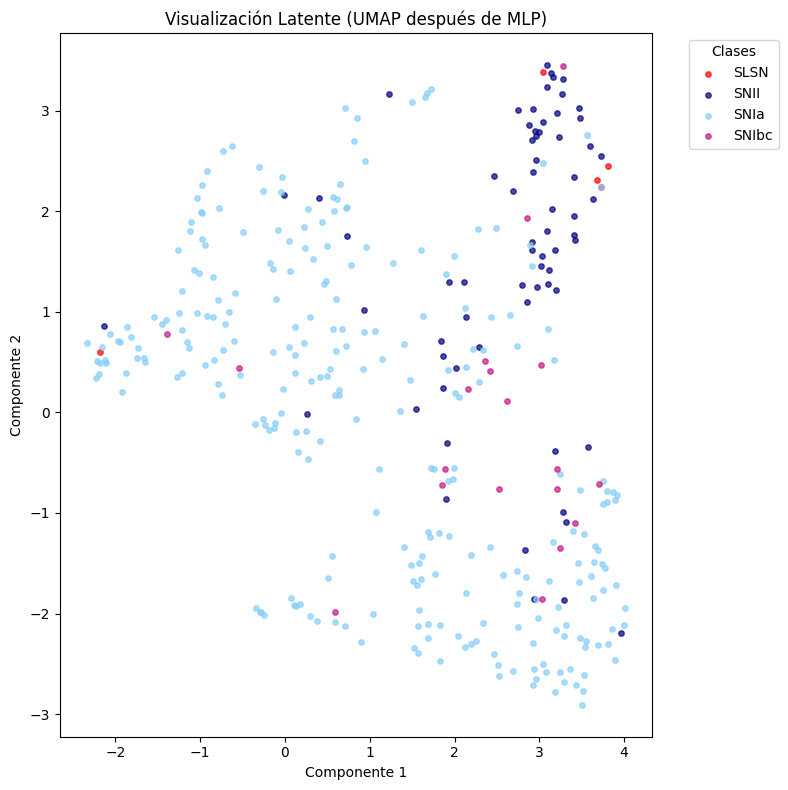

In [96]:
# 2. DESPUÉS DE LA MLP
plot_latent_space(
    Z_2D_umap,
    y_latent,
    'Visualización Latente (UMAP después de MLP)',
    class_names_sn,
    custom_colors=custom_colors  # Agrega este parámetro
)

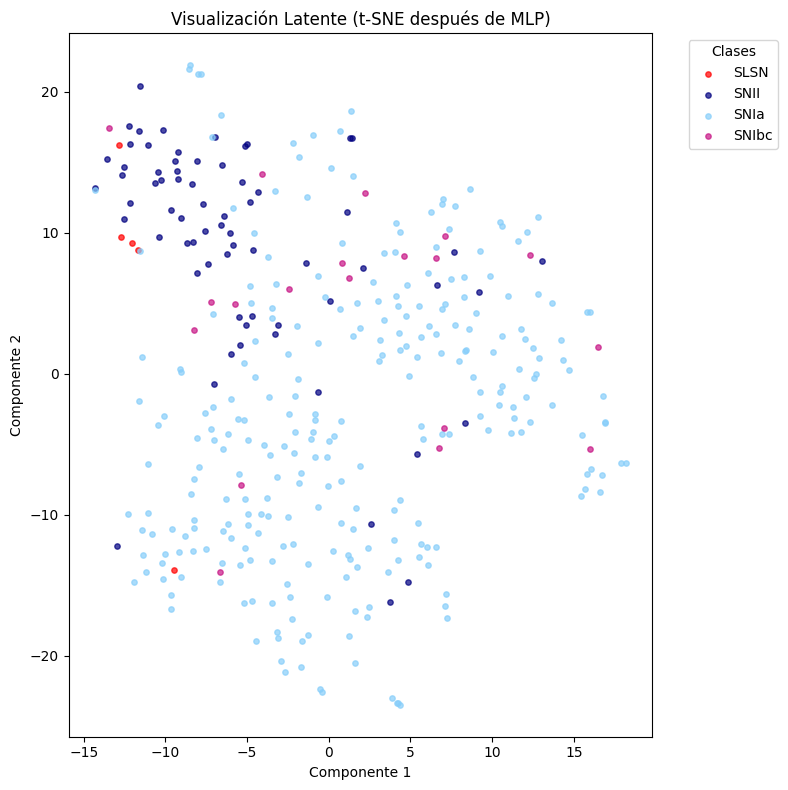

In [97]:
plot_latent_space(
    Z_2D_tsne,
    y_latent,
    'Visualización Latente (t-SNE después de MLP)',
    class_names_sn,
    custom_colors=custom_colors  # Agrega este parámetro también
)

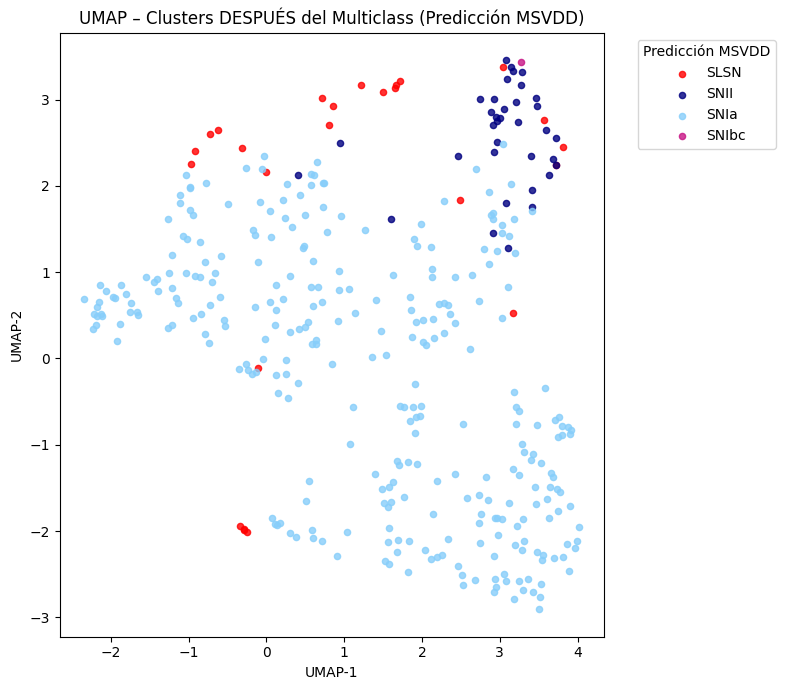

In [98]:
# 3. Clusters por predicción MSVDD
plot_umap_by_pred(Z_2D_umap, Z_pred_msvdd, class_names_sn, custom_colors=custom_colors)

In [100]:
from sklearn.svm import OneClassSVM
import numpy as np
import pandas as pd
from sklearn.metrics import classification_report, accuracy_score

# Nombres de las 4 clases de supernovas (obtenidas del LabelEncoder 'le')
class_names_sn = list(le.classes_)

# 1. Recolección de puntajes de decisión para todas las clases
# La matriz será (N_muestras, N_clases) = (X_latent.shape[0], num_classes)
decision_scores = np.zeros((X_latent.shape[0], num_classes))

for class_id, ocsvm in ocsvm_models.items():
    # Obtener el puntaje de decisión para TODAS las muestras de test
    # El valor es la distancia firmada al borde de la esfera de esa clase.
    # Puntaje > 0: Dentro de la esfera (Normalidad)
    # Puntaje < 0: Fuera de la esfera (Anomalía)
    decision_scores[:, class_id] = ocsvm.decision_function(X_latent)

# 2. Regla de Clasificación MSVDD: Elegir la esfera más cercana (el puntaje más alto)
# argmax devuelve el índice de la columna con el valor más alto (más cercano o dentro de la esfera)
Z_pred_msvdd = np.argmax(decision_scores, axis=1)

# 3. Puntaje de Anomalía (Puntaje de Detección de Outlier)
# La detección de anomalía se basa en el puntaje de decisión MÁXIMO para ese punto.
anomaly_score = np.max(decision_scores, axis=1)

# El MSVDD clasifica un punto como ANOMALÍA si el score máximo es negativo (fuera de todas las esferas)
MSVDD_THRESHOLD = 0.0  # El umbral estándar del OCSVM es 0
anomalias_msvdd_indices = np.where(anomaly_score < MSVDD_THRESHOLD)[0]

print(f"\n--- Resultados del Clasificador MSVDD ---")

# Evaluación de la Clasificación (ignora las anomalías por ahora)
accuracy = accuracy_score(y_latent, Z_pred_msvdd)
print(f"Clasificación MSVDD (Accuracy): {accuracy:.4f}")
print(f"Reporte de Clasificación (MSVDD):\n{classification_report(y_latent, Z_pred_msvdd, target_names=class_names_sn)}")

# Evaluación de la Detección de Anomalías
print(f"Número de Muestras Totales: {X_latent.shape[0]}")
print(f"Número de Anomalías Detectadas (Score < 0): {len(anomalias_msvdd_indices)}")

# Crear un DataFrame para la inspección
df_msvdd_results = pd.DataFrame({
    'Y_true_int': y_latent,
    'Y_pred_MSVDD_int': Z_pred_msvdd,
    'Max_Score': anomaly_score
})

# Mapear los enteros a nombres de clase
df_msvdd_results['Y_true'] = [class_names_sn[y] for y in df_msvdd_results['Y_true_int']]
df_msvdd_results['Y_pred_MSVDD'] = [class_names_sn[y] for y in df_msvdd_results['Y_pred_MSVDD_int']]


# Identificar las muestras clasificadas como anomalías por MSVDD
anomalias_msvdd_df = df_msvdd_results.iloc[anomalias_msvdd_indices].copy()

print("\nAnomalías (Score < 0) - Muestras a Inspeccionar (Top 5):")
print(anomalias_msvdd_df[['Y_true', 'Y_pred_MSVDD', 'Max_Score']].head(5))

# Opcional: Mostrar las 5 muestras más anómalas (los scores más negativos)
print("\nTop 5 Muestras más Anómalas (Score más negativo):")
anomalias_ordenadas = df_msvdd_results.sort_values(by='Max_Score').head(5)
print(anomalias_ordenadas[['Y_true', 'Y_pred_MSVDD', 'Max_Score']])


--- Resultados del Clasificador MSVDD ---
Clasificación MSVDD (Accuracy): 0.7753
Reporte de Clasificación (MSVDD):
              precision    recall  f1-score   support

        SLSN       0.12      0.60      0.20         5
        SNII       0.86      0.44      0.58        68
        SNIa       0.82      0.91      0.86       273
       SNIbc       1.00      0.05      0.10        19

    accuracy                           0.78       365
   macro avg       0.70      0.50      0.44       365
weighted avg       0.83      0.78      0.76       365

Número de Muestras Totales: 365
Número de Anomalías Detectadas (Score < 0): 34

Anomalías (Score < 0) - Muestras a Inspeccionar (Top 5):
   Y_true Y_pred_MSVDD  Max_Score
14   SNIa         SNIa  -0.000419
36   SNIa         SLSN  -0.252974
53   SNIa         SLSN  -0.225121
54   SNIa         SNIa  -0.000261
63   SNIa         SLSN  -0.155433

Top 5 Muestras más Anómalas (Score más negativo):
    Y_true Y_pred_MSVDD  Max_Score
117   SNIa         SLS

In [101]:
from sklearn.model_selection import train_test_split

# Recuperamos todos los OIDs del DataFrame filtrado (df_sn)
oids = df_sn['oid'].values

# Replicamos la división exacta de train/test (usando el mismo random_state=42 y stratify=y_int) para obtener los OIDs del conjunto de prueba (oids_test).
# Usamos '_' para ignorar los arrays que no necesitamos de esta división
_, oids_test, _, _ = train_test_split(
    oids, # El array de OIDs
    y_int,
    test_size=0.20,
    random_state=42,
    stratify=y_int
)

df_anomalies_results = pd.DataFrame({
    'oid': oids_test,
    'Clase_Verdadera': le.inverse_transform(y_latent),
    'Clase_Predicha_MSVDD': le.inverse_transform(Z_pred_msvdd),
    'Max_Score': anomaly_score
})

# Filtrar y Mostrar Anomalías (Max_Score < 0)
# Una anomalía es cualquier objeto con un puntaje máximo de decisión negativo (fuera de todas las esferas).
anomaly_mask = (df_anomalies_results['Max_Score'] < 0.0)
df_anomalies = df_anomalies_results[anomaly_mask].copy()

# 4. Extraer y listar los OIDs de las anomalías
anomaly_oids = df_anomalies['oid'].values

print("\n"+"="*70)
print(f"ANOMALÍAS DETECTADAS por MSVDD: {len(anomaly_oids)} objetos")
print("="*70)
print(anomaly_oids)

print("\nDetalles (ordenado por 'extrañeza', score más negativo = más anómalo):")
print(df_anomalies[['oid', 'Clase_Verdadera', 'Clase_Predicha_MSVDD', 'Max_Score']]
      .sort_values(by='Max_Score').to_string(index=False))

# 5. Exportar a CSV
df_anomalies[['oid', 'Clase_Verdadera', 'Clase_Predicha_MSVDD', 'Max_Score']].to_csv(
    'msvdd_anomalies_oids.csv', index=False
)
print("\nAnomalías exportadas a 'msvdd_anomalies_oids.csv' para su inspección.")


ANOMALÍAS DETECTADAS por MSVDD: 34 objetos
['ZTF18abhhnnv' 'ZTF19abakdjd' 'ZTF18abwwuug' 'ZTF20aambbfn'
 'ZTF17aadlxmv' 'ZTF20aagnbes' 'ZTF19aarkpif' 'ZTF19abqmpsr'
 'ZTF18aawczad' 'ZTF19abqgtqo' 'ZTF19abnagzk' 'ZTF18acptgzz'
 'ZTF19abvjdfc' 'ZTF18abmxfrc' 'ZTF18acqsztr' 'ZTF18acbwaxk'
 'ZTF19aaqxosb' 'ZTF18abskove' 'ZTF20abeohfn' 'ZTF19acjifxp'
 'ZTF19aaeoqkk' 'ZTF19abdyyut' 'ZTF19acxphhl' 'ZTF19aaywatq'
 'ZTF18acqqyah' 'ZTF18acnnevs' 'ZTF18aazcoob' 'ZTF20aaycmhl'
 'ZTF18absoomk' 'ZTF19abaukyt' 'ZTF19abucwzt' 'ZTF19aaeoqst'
 'ZTF19aalzrrz' 'ZTF20aadvbni']

Detalles (ordenado por 'extrañeza', score más negativo = más anómalo):
         oid Clase_Verdadera Clase_Predicha_MSVDD  Max_Score
ZTF19abvjdfc            SNIa                 SLSN  -0.299071
ZTF18acbwaxk            SNII                 SLSN  -0.299071
ZTF19aaeoqkk            SNIa                 SLSN  -0.299027
ZTF18absoomk            SNIa                 SLSN  -0.298424
ZTF19abakdjd            SNIa                 SLSN  -0.25297

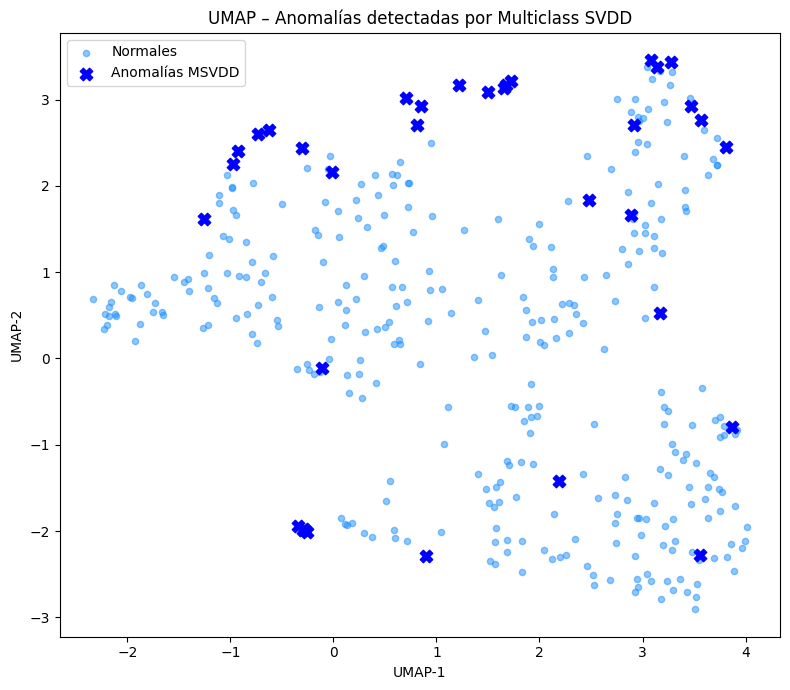

In [99]:
# 4. Anomalías (puedes cambiar los colores aquí también)
plot_umap_anomalies(
    Z_2D_umap,
    anomaly_score,
    color_normal='dodgerblue',    # Gris claro para normales
    color_anomaly='blue'    # Rojo para anomalías
)

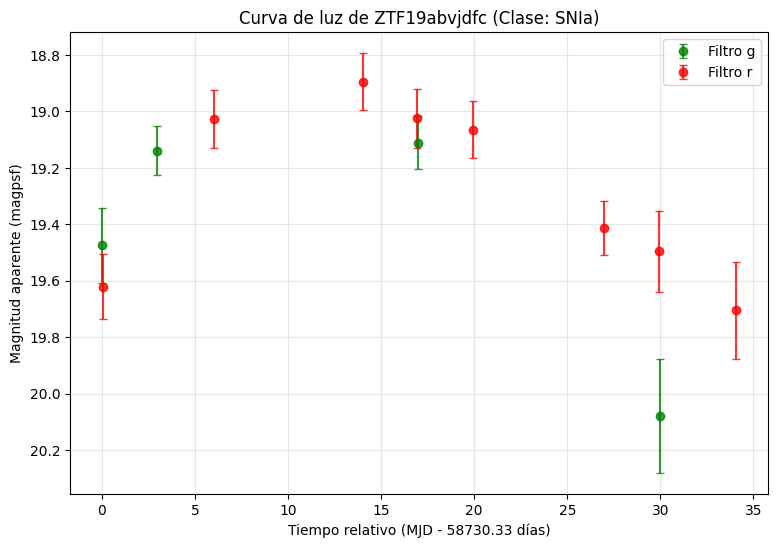

In [102]:
import pandas as pd
import matplotlib.pyplot as plt

# =================================================================
# FUNCIÓN DE PLOTEO DE CURVA DE LUZ PARA UNA ANOMALÍA
# =================================================================

def plot_anomaly_lightcurve(oid_target, detections_df, cross_df):
    """
    Grafica la curva de luz para un objeto específico.

    Args:
        oid_target (str): El OID del objeto (anomalía) a graficar.
        detections_df (pd.DataFrame): DataFrame con todas las detecciones (detecciones).
        cross_df (pd.DataFrame): DataFrame con el crossmatch de clases (cross).
    """

    # 1. Preparar datos
    # Solo necesitamos las columnas 'oid' y 'classALeRCE' del crossmatch
    cross_subset = cross_df[['oid', 'classALeRCE']].drop_duplicates(subset='oid')

    # Unir detecciones con su clase
    df_merged = detections_df.merge(cross_subset, left_on='objectId', right_on='oid', how='left')

    # Seleccionar el objeto de interés
    obj = df_merged[df_merged['objectId'] == oid_target]

    if obj.empty:
        print(f"No se encontró el objeto {oid_target} en las detecciones. Verifica el nombre.")
        return

    # Obtener la clase y el primer MJD (tiempo de referencia t0)
    clase = obj['classALeRCE'].iloc[0] if not obj['classALeRCE'].empty else "Clase Desconocida"
    mjd_min = obj['mjd'].min()

    # 2. Graficar curva de luz
    plt.figure(figsize=(9, 6))

    # Itera sobre los filtros (fid 1 es g, fid 2 es r en ZTF)
    for fid, color, nombre in zip([1, 2], ['g', 'r'], ['Filtro g', 'Filtro r']):
        subset = obj[obj['fid'] == fid]
        if not subset.empty:
            plt.errorbar(
                subset['mjd'] - mjd_min,  # Usar tiempo relativo (días desde la primera detección)
                subset['magpsf'],
                yerr=subset['sigmapsf'],
                fmt='o',
                color=color,
                label=nombre,
                alpha=0.8,
                capsize=3 # Muestra la barra de error más claramente
            )

    plt.gca().invert_yaxis()  # En magnitudes: menor = más brillante
    plt.title(f"Curva de luz de {oid_target} (Clase: {clase})")
    plt.xlabel(f"Tiempo relativo (MJD - {mjd_min:.2f} días)")
    plt.ylabel("Magnitud aparente (magpsf)")
    plt.legend()
    plt.grid(True, alpha=0.3)
    plt.show()

# =================================================================
# EJECUCIÓN (Modifica el OID aquí)
# =================================================================

# Reemplaza este OID con una de las anomalías detectadas por MSVDD
oid_anomalia = 'ZTF19abvjdfc'

# Asegúrate de que las variables 'detecciones' y 'cross' estén cargadas
# con los DataFrames de tu Google Drive.
try:
    plot_anomaly_lightcurve(oid_anomalia, detecciones, cross)
except NameError:
    print("Error: Asegúrate de que las variables 'detecciones' y 'cross' estén cargadas en tu notebook.")